In [28]:
try:
    import google.colab
    google.colab.drive.mount('/content/drive/')
except:
    pass

from sklearn import svm
import numpy as np
! pip install pytorch_lightning
! pip install albumentations
! pip install tqdm
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import f1_score
import albumentations.pytorch as AP
import pytorch_lightning as pl
import os
import cv2
from tqdm import tqdm
import albumentations as A
import torchvision.models as models
import torch
import glob

train_path = '../content/drive/MyDrive/Train'
test_path = '../content/drive/MyDrive/Test'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Read Data & Preprocess

In [29]:
def preprocess_img(img, new_size=256, normalize=True, more_transforms=None):
    transforms_list = [
        A.SmallestMaxSize(max_size=new_size),
        A.CenterCrop(new_size, new_size),
    ]
    if normalize: transforms_list.append(A.Normalize(mean=[0.277, 0.277, 0.277], std=[0.254, 0.246, 0.223]))
    if more_transforms: transforms_list.extend(more_transforms)
    transform = A.Compose(transforms_list)
    img_p = transform(image=img)['image']
    return img_p

In [30]:
def read_data(train_path, gray=False, new_size= 256, normalize=False, transpose=False, more_transforms=None):
    flooded_path = train_path + '/flooded/*.jpg'
    non_flooded_path = train_path + '/non-flooded/*.jpg'
    print(flooded_path)

    x_data, y_data= [], []
    
    for filename in tqdm(glob.glob(flooded_path)):
            img = cv2.imread(filename, 0 if gray else cv2.COLOR_BGR2RGB)
            img_p = preprocess_img(img, new_size, normalize, more_transforms)
            if transpose: img_p = img_p.transpose(2,0,1)
            x_data.append(img_p)
            y_data.append(1)

        
    for filename in tqdm(glob.glob(non_flooded_path)):
            img = cv2.imread(filename, 0 if gray else cv2.COLOR_BGR2RGB)
            img_p = preprocess_img(img, new_size, normalize,  more_transforms)
            if transpose: img_p = img_p.transpose(2,0,1)
            x_data.append(img_p)
            y_data.append(0)

    x_data,  y_data = np.array(x_data), np.array(y_data)

    
    return x_data, y_data


def read_test(test_path, gray=False, new_size=256, normalize=False, transpose=False, more_transforms=None):
        test_path = test_path + '/*.jpg'
        
        x_data= []
        
        for filename in tqdm(sorted(glob.glob(test_path))):
                img = cv2.imread(filename, 0 if gray else cv2.COLOR_BGR2RGB)
                img_p = preprocess_img(img, new_size, normalize, more_transforms)
                if transpose: img_p = img_p.transpose(2,0,1)
                x_data.append(img_p)
        
        x_test = np.array(x_data)
        
        return x_test

### Feature Extraction

In [71]:

class ConvNet(pl.LightningModule):
    '''
    ShuffleNetV2 Model
    '''
    def __init__(self):
        super(ConvNet, self).__init__()
        self.model = models.shufflenet_v2_x1_0(pretrained=True)
        self.model.eval()

        #self.model = models.resnet50(weights="DEFAULT")
        #self.model = nn.Sequential(*list(self.model.children())[:-1])
        #self.model.eval()
        
    def forward(self, x):
        '''
        Forward method to pass a given input batch to the model and return its predictions
        '''
        x = self.model(x.unsqueeze(0))
        return x

model = ConvNet()


def deep_features(img):
    '''
    Produces a feature vector for the image using a pretrained model
    '''
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    img = img.to(device)
    model = ConvNet().to(device)
    model.eval()
    feat = model(img)
    return feat.detach().cpu().numpy()



def apply_deep_features(x_data):
    '''
    Simply applies the deep_feature function to each image in x_data
    '''
    x_data_f = []
    for x in tqdm(x_data):
        feat = deep_features(x)
        feat = np.squeeze(feat)
        x_data_f.append(feat)
    return np.array(x_data_f)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Model Pipeline

In [33]:
more_transforms = [AP.transforms.ToTensorV2()]          # PyTorch deals with tensors on the GPU not numpy arrays
x_data, y_data = read_data(train_path, gray=False, normalize=True, new_size=224, more_transforms=more_transforms)

../content/drive/MyDrive/Train/flooded/*.jpg


100%|██████████| 461/461 [01:08<00:00,  6.76it/s]
<ipython-input-30-408390c685d3>:23: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  x_data,  y_data = np.array(x_data), np.array(y_data)
<ipython-input-30-408390c685d3>:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_data,  y_data = np.array(x_data), np.array(y_data)


In [72]:
x_data_f = apply_deep_features(x_data)

100%|██████████| 922/922 [01:14<00:00, 12.46it/s]


In [73]:
model = svm.SVC(C=60, kernel='rbf')
model.fit(x_data_f, y_data)

SVC(C=60)

In [74]:
model.predict(x_data_f)
f1_score(y_data, model.predict(x_data_f))

1.0

In [37]:
#!pip install gdown
#!gdown --id "1SNpotKz99HDHeIKmXn4nMzxZSctnEhfW"

In [38]:
#import pickle
#with open('./svm_model.pkl', 'rb') as f:
#    model = pickle.load(f)

#### Testing

In [39]:
x_test = read_test(test_path, gray=False, normalize=True, new_size=224, more_transforms=more_transforms)
print(x_test.shape)

100%|██████████| 232/232 [00:18<00:00, 12.46it/s]
<ipython-input-30-408390c685d3>:40: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  x_test = np.array(x_data)
<ipython-input-30-408390c685d3>:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test = np.array(x_data)


(232,)


100%|██████████| 232/232 [01:58<00:00,  1.96it/s]


In [75]:
x_test_f = apply_deep_features(x_test)


  0%|          | 0/232 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 232/232 [00:18<00:00, 12.79it/s]


In [76]:
preds = model.predict(x_test_f)

print(x_test_f.shape)

(232, 1000)


In [77]:
# check length of preds
# Make a numpy array of labels where the first 115 are 1s and the second 115 are 0s
labels = np.concatenate((np.zeros(116), np.ones(116)))

Accuracy:  0.9612068965517241
Macro F1 Score:  0.9611715481171548


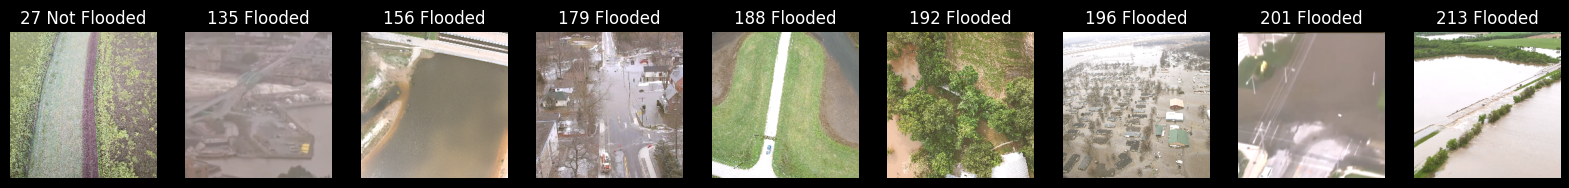

In [90]:
# check model accuracy and macro f1 score
from sklearn.metrics import accuracy_score, f1_score

print("Accuracy: ", accuracy_score(labels, preds))

print("Macro F1 Score: ", f1_score(labels, preds, average='macro'))
# Resnet has accuracy 0.9698 (4th place) and Macro F1 0.9698
# Shufflenet has accuracy 0.9612 (9th place) and Macro F1 0.9611



mistake_inds = np.where(labels != preds)[0]

# Let's plot all the images with an error
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import torch

# plot the miscalssified images
fig, axs = plt.subplots(1, len(mistake_inds), figsize=(20, 20))
for i, ind in enumerate(mistake_inds):
    img = x_test[ind].numpy()
    img = np.transpose(img, (1, 2, 0))
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    axs[i].imshow(img)
    # set flooded or not labels
    if labels[ind] == 1:
        axs[i].set_title(f"{ind} Flooded")
    else:
        axs[i].set_title(f"{ind} Not Flooded")
    axs[i].axis('off')
plt.show()



In [85]:
def CV_Evaluate(model, x_data, y_data):
    """
    Evaluates the performance (F1) of the given model using leave-one-out or repeated KFold cross validation.
    The fact that the function is defined here is a violation to the standards of ths project [Awaiting Fix]
    """
    x_data = np.array(x_data)
    y_data = np.array(y_data)
    cval = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
    f1_scores = []
    for i, j in tqdm(cval.split(x_data)):           # splits yields indecies of the points in the current split
        x_train, x_val = x_data[i], x_data[j]
        y_train, y_val = y_data[i], y_data[j]
        model.fit(x_train, y_train)
        y_pred = model.predict(x_val)
        # compute weighted f1 score
        f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    mean_f1_score = sum(f1_scores) / len(f1_scores)
    var_f1_score = sum((f1_scores[i] - mean_f1_score)**2 for i in range(len(f1_scores))) / len(f1_scores)
    return mean_f1_score, var_f1_score, f1_scores

Cross_F1, Var_CrossF1, f1_scores = CV_Evaluate(model, x_data_f, y_data)

50it [00:07,  6.72it/s]


In [86]:
print(Cross_F1, np.sqrt(Var_CrossF1))
# Resnet F1=0.977 and Var = 0.012 for 5-Fold
# Resnet F1=0.977 and Var = 0.017 for 10-Fold

# Now lets uncomment Shufflenet and check
# Shufflenet F1=0.9802 and Var = 0.01 for 5-Fold.  
# ShuffleNet F1=0.9804 and Var = 0.014 for 10 Fold


0.9802691200330008 0.01019387910587989
